In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.nn import RelGraphConv
from sklearn.preprocessing import LabelEncoder
import random
import pickle

In [2]:
# 1. Load cleaned triplet data
df = pd.read_csv("triplets.csv")
df.dropna(subset=['subject', 'predicate', 'object', 'image_id'], inplace=True)

In [3]:
# 2. Encode entities and relations
entity_encoder = LabelEncoder()
relation_encoder = LabelEncoder()
all_entities = pd.unique(df[['subject', 'object']].values.ravel())
all_relations = df['predicate'].unique()
entity_encoder.fit(all_entities)
relation_encoder.fit(all_relations)

df['subj_id'] = entity_encoder.transform(df['subject'])
df['obj_id'] = entity_encoder.transform(df['object'])
df['rel_id'] = relation_encoder.transform(df['predicate'])

In [4]:
# 3. Create DGL graph
n_nodes = len(entity_encoder.classes_)
n_rels = len(relation_encoder.classes_)
src = torch.tensor(df['subj_id'].values)
dst = torch.tensor(df['obj_id'].values)
rel = torch.tensor(df['rel_id'].values)

g = dgl.heterograph({('entity', str(r), 'entity'): (src[rel == r], dst[rel == r]) for r in range(n_rels)})
g = dgl.to_homogeneous(g)
g.edata['rel_type'] = rel

In [5]:
# 4. Define R-GCN
class RGCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_rels):
        super().__init__()
        self.conv1 = RelGraphConv(in_feats, h_feats, num_rels)
        self.conv2 = RelGraphConv(h_feats, h_feats, num_rels)

    def forward(self, g, feat, etypes):
        x = self.conv1(g, feat, etypes)
        x = F.relu(x)
        x = self.conv2(g, x, etypes)
        return x

In [6]:
# 5. Train with Triplet Loss
features = torch.eye(n_nodes)
model = RGCN(n_nodes, 128, n_rels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

image_to_entities = df.groupby('image_id').apply(lambda x: set(x['subj_id']).union(x['obj_id'])).to_dict()
image_ids = list(image_to_entities.keys())

In [7]:
epochs = 10
margin = 1.0
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    node_emb = model(g, features, g.edata['rel_type'])

    loss = 0
    count = 0
    for _ in range(100):
        anchor_entity = random.choice(range(n_nodes))
        pos_imgs = [img for img, ents in image_to_entities.items() if anchor_entity in ents]
        neg_imgs = [img for img, ents in image_to_entities.items() if anchor_entity not in ents]
        if not pos_imgs or not neg_imgs:
            continue

        pos_img = random.choice(pos_imgs)
        neg_img = random.choice(neg_imgs)
        pos_emb = torch.stack([node_emb[e] for e in image_to_entities[pos_img]]).mean(dim=0)
        neg_emb = torch.stack([node_emb[e] for e in image_to_entities[neg_img]]).mean(dim=0)
        anchor_emb = node_emb[anchor_entity]

        sim_pos = F.cosine_similarity(anchor_emb, pos_emb, dim=0)
        sim_neg = F.cosine_similarity(anchor_emb, neg_emb, dim=0)
        loss += F.relu(margin - sim_pos + sim_neg)
        count += 1

    if count > 0:
        loss = loss / count
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 6272850944 bytes.

In [8]:
import torch.nn.functional as F
import random

epochs = 10
margin = 1.0
steps_per_epoch = 50  # Giảm từ 100 xuống 50 hoặc ít hơn

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    node_emb = model(g, features, g.edata['rel_type'])

    total_loss = 0.0
    valid_steps = 0

    for _ in range(steps_per_epoch):
        anchor_entity = random.choice(range(n_nodes))
        pos_imgs = [img for img, ents in image_to_entities.items() if anchor_entity in ents]
        neg_imgs = [img for img, ents in image_to_entities.items() if anchor_entity not in ents]

        if not pos_imgs or not neg_imgs:
            continue

        pos_img = random.choice(pos_imgs)
        neg_img = random.choice(neg_imgs)

        # Lấy embedding ảnh trung bình
        pos_emb = torch.stack([node_emb[e] for e in image_to_entities[pos_img]]).mean(dim=0)
        neg_emb = torch.stack([node_emb[e] for e in image_to_entities[neg_img]]).mean(dim=0)
        anchor_emb = node_emb[anchor_entity]

        # Tính similarity
        sim_pos = F.cosine_similarity(anchor_emb, pos_emb, dim=0)
        sim_neg = F.cosine_similarity(anchor_emb, neg_emb, dim=0)

        # Tính triplet loss
        triplet_loss = F.relu(margin - sim_pos + sim_neg)
        triplet_loss.backward()  # Backprop từng bước nhỏ
        total_loss += triplet_loss.item()
        valid_steps += 1

    if valid_steps > 0:
        optimizer.step()
        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {total_loss / valid_steps:.4f}")
    else:
        print(f"Epoch {epoch+1}/{epochs} | No valid steps (skipped)")

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 6272850944 bytes.

In [9]:
epochs = 10
margin = 1.0
steps_per_epoch = 30  # Giảm để an toàn hơn

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    with torch.no_grad():  # Tránh giữ đồ thị lớn
        node_emb = model(g, features, g.edata['rel_type']).detach()

    total_loss = 0.0
    valid_steps = 0

    for _ in range(steps_per_epoch):
        anchor_entity = random.choice(range(n_nodes))
        pos_imgs = [img for img, ents in image_to_entities.items() if anchor_entity in ents]
        neg_imgs = [img for img, ents in image_to_entities.items() if anchor_entity not in ents]
        if not pos_imgs or not neg_imgs:
            continue

        pos_img = random.choice(pos_imgs)
        neg_img = random.choice(neg_imgs)

        pos_emb = torch.stack([node_emb[e] for e in image_to_entities[pos_img]]).mean(dim=0)
        neg_emb = torch.stack([node_emb[e] for e in image_to_entities[neg_img]]).mean(dim=0)
        anchor_emb = node_emb[anchor_entity]

        # Đảm bảo có gradient bằng cách clone và set requires_grad
        anchor_emb = anchor_emb.clone().detach().requires_grad_(True)

        sim_pos = F.cosine_similarity(anchor_emb, pos_emb, dim=0)
        sim_neg = F.cosine_similarity(anchor_emb, neg_emb, dim=0)

        triplet_loss = F.relu(margin - sim_pos + sim_neg)
        triplet_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += triplet_loss.item()
        valid_steps += 1

    if valid_steps > 0:
        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {total_loss / valid_steps:.4f}")
    else:
        print(f"Epoch {epoch+1}/{epochs} | No valid steps (skipped)")

Epoch 1/10 | Avg Loss: 0.9810
Epoch 2/10 | Avg Loss: 0.9905
Epoch 3/10 | Avg Loss: 0.9914
Epoch 4/10 | Avg Loss: 0.9863
Epoch 5/10 | Avg Loss: 1.0014
Epoch 6/10 | Avg Loss: 0.9844
Epoch 7/10 | Avg Loss: 0.9935
Epoch 8/10 | Avg Loss: 0.9886
Epoch 9/10 | Avg Loss: 0.9997
Epoch 10/10 | Avg Loss: 0.9944


In [10]:
# 6. Save model and encoders
torch.save(model.state_dict(), "rgcn_triplet_model.pt")
with open("entity_encoder.pkl", "wb") as f:
    pickle.dump(entity_encoder, f)
with open("relation_encoder.pkl", "wb") as f:
    pickle.dump(relation_encoder, f)

In [12]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
import random
import dgl
from dgl.nn import RelGraphConv
from tqdm import tqdm

# 1. Đọc và xử lý dữ liệu
df = pd.read_csv("triplets.csv")
df.dropna(subset=["subject", "predicate", "object"], inplace=True)
df.drop_duplicates(subset=["subject", "predicate", "object", "image_id"], inplace=True)
df = df.sample(n=10000, random_state=42)  # Giảm dữ liệu nếu RAM yếu

# 2. Mã hóa entities và relations
entity_encoder = LabelEncoder()
relation_encoder = LabelEncoder()

all_entities = pd.unique(df[['subject', 'object']].values.ravel())
all_relations = df['predicate'].unique()

entity_encoder.fit(all_entities)
relation_encoder.fit(all_relations)

df['subj_id'] = entity_encoder.transform(df['subject'])
df['obj_id'] = entity_encoder.transform(df['object'])
df['rel_id'] = relation_encoder.transform(df['predicate'])

n_entities = len(entity_encoder.classes_)
n_relations = len(relation_encoder.classes_)

# 3. Xây đồ thị R-GCN
src = torch.tensor(df['subj_id'].values)
dst = torch.tensor(df['obj_id'].values)
rel = torch.tensor(df['rel_id'].values)

g = dgl.heterograph({
    ('entity', str(r), 'entity'): (src[rel == r], dst[rel == r])
    for r in range(n_relations)
})
g = dgl.to_homogeneous(g)
g = g.int()  # DGL yêu cầu dữ liệu dạng int

# 4. Định nghĩa mô hình R-GCN
class RGCN(nn.Module):
    def __init__(self, num_nodes, num_rels, emb_dim=64, h_dim=32, num_layers=2):
        super(RGCN, self).__init__()
        self.embed = nn.Embedding(num_nodes, emb_dim)
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(RelGraphConv(emb_dim if i == 0 else h_dim, h_dim, num_rels, regularizer='basis', num_bases=8))

    def forward(self, g, etypes):
        h = self.embed.weight
        for layer in self.layers:
            h = layer(g, h, etypes)
            h = F.relu(h)
        return h

# 5. Chuẩn bị huấn luyện
model = RGCN(n_entities, n_relations)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)

# Tạo danh sách triplets để train
triplets = list(zip(df['subj_id'], df['rel_id'], df['obj_id']))

# Chuyển edge type về dạng torch tensor
etype_tensor = torch.tensor([e for _, e, _ in triplets])

# 6. Vòng huấn luyện
epochs = 10
batch_size = 1024

for epoch in range(epochs):
    model.train()
    total_loss = 0
    random.shuffle(triplets)

    for i in range(0, len(triplets), batch_size):
        batch = triplets[i:i+batch_size]
        anchors = []
        positives = []
        negatives = []

        for s, r, o in batch:
            anchors.append(s)
            positives.append(o)

            # Tạo negative sample
            neg = random.randint(0, n_entities - 1)
            while (s, r, neg) in triplets:
                neg = random.randint(0, n_entities - 1)
            negatives.append(neg)

        # === CHẠY MODEL TRONG MỖI BATCH ===
        node_embeddings = model(g, g.edata[dgl.ETYPE])

        anchors = node_embeddings[torch.tensor(anchors)]
        positives = node_embeddings[torch.tensor(positives)]
        negatives = node_embeddings[torch.tensor(negatives)]

        loss = loss_fn(anchors, positives, negatives)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / (len(triplets) // batch_size)
    print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f}")


Epoch 1/10 | Avg Loss: 2.0750
Epoch 2/10 | Avg Loss: 0.5937
Epoch 3/10 | Avg Loss: 0.4893
Epoch 4/10 | Avg Loss: 0.4233
Epoch 5/10 | Avg Loss: 0.4051
Epoch 6/10 | Avg Loss: 0.3793
Epoch 7/10 | Avg Loss: 0.3788
Epoch 8/10 | Avg Loss: 0.3571
Epoch 9/10 | Avg Loss: 0.3542
Epoch 10/10 | Avg Loss: 0.3476


In [13]:
# Lưu model
torch.save(model.state_dict(), "rgcn_triplet_model.pt")

# Tính embedding cho tất cả entity
with torch.no_grad():
    all_entity_ids = torch.arange(n_entities)
    all_embeddings = model.embeddings(all_entity_ids).cpu().numpy()

# Lưu embeddings và encoders
import pickle
with open("entity_embeddings.pkl", "wb") as f:
    pickle.dump(all_embeddings, f)
with open("entity_encoder.pkl", "wb") as f:
    pickle.dump(entity_encoder, f)
with open("image_map.pkl", "wb") as f:
    pickle.dump(entity_id_to_image_ids, f)  # bạn cần tạo trước dict này

AttributeError: 'RGCN' object has no attribute 'embeddings'

In [14]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
import random
import dgl
from dgl.nn import RelGraphConv
from tqdm import tqdm
import pickle

# 1. Đọc và xử lý dữ liệu
df = pd.read_csv("triplets.csv")
df.dropna(subset=["subject", "predicate", "object"], inplace=True)
df.drop_duplicates(subset=["subject", "predicate", "object", "image_id"], inplace=True)
df = df.sample(n=10000, random_state=42)  # Giảm dữ liệu nếu RAM yếu

In [15]:
# 2. Mã hóa entities và relations
entity_encoder = LabelEncoder()
relation_encoder = LabelEncoder()

all_entities = pd.unique(df[['subject', 'object']].values.ravel())
all_relations = df['predicate'].unique()

entity_encoder.fit(all_entities)
relation_encoder.fit(all_relations)

df['subj_id'] = entity_encoder.transform(df['subject'])
df['obj_id'] = entity_encoder.transform(df['object'])
df['rel_id'] = relation_encoder.transform(df['predicate'])

n_entities = len(entity_encoder.classes_)
n_relations = len(relation_encoder.classes_)

In [16]:
# 3. Xây đồ thị R-GCN
src = torch.tensor(df['subj_id'].values)
dst = torch.tensor(df['obj_id'].values)
rel = torch.tensor(df['rel_id'].values)

g = dgl.heterograph({
    ('entity', str(r), 'entity'): (src[rel == r], dst[rel == r])
    for r in range(n_relations)
})
g = dgl.to_homogeneous(g)
g = g.int()

# Lưu edge type cho đồ thị homogeneous
g.edata['rel_type'] = rel_tensor = torch.tensor([r for r in df['rel_id']])

In [17]:
# 4. Định nghĩa mô hình R-GCN
class RGCN(nn.Module):
    def __init__(self, num_nodes, num_rels, emb_dim=64, h_dim=32, num_layers=2):
        super(RGCN, self).__init__()
        self.embed = nn.Embedding(num_nodes, emb_dim)
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(
                RelGraphConv(emb_dim if i == 0 else h_dim, h_dim, num_rels, regularizer='basis', num_bases=8)
            )

    def forward(self, g, etypes):
        h = self.embed.weight
        for layer in self.layers:
            h = layer(g, h, etypes)
            h = F.relu(h)
        return h

In [18]:
# 5. Chuẩn bị huấn luyện
model = RGCN(n_entities, n_relations)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)

triplets = list(zip(df['subj_id'], df['rel_id'], df['obj_id']))
etype_tensor = g.edata['rel_type']
batch_size = 1024
epochs = 10

In [19]:
# 6. Huấn luyện
for epoch in range(epochs):
    model.train()
    total_loss = 0
    random.shuffle(triplets)

    for i in range(0, len(triplets), batch_size):
        batch = triplets[i:i+batch_size]
        anchors, positives, negatives = [], [], []

        for s, r, o in batch:
            anchors.append(s)
            positives.append(o)
            neg = random.randint(0, n_entities - 1)
            while (s, r, neg) in triplets:
                neg = random.randint(0, n_entities - 1)
            negatives.append(neg)

        node_embeddings = model(g, etype_tensor)
        anchors = node_embeddings[torch.tensor(anchors)]
        positives = node_embeddings[torch.tensor(positives)]
        negatives = node_embeddings[torch.tensor(negatives)]

        loss = loss_fn(anchors, positives, negatives)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / (len(triplets) // batch_size)
    print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f}")

Epoch 1/10 | Avg Loss: 1.1003
Epoch 2/10 | Avg Loss: 0.5077
Epoch 3/10 | Avg Loss: 0.4342
Epoch 4/10 | Avg Loss: 0.4135
Epoch 5/10 | Avg Loss: 0.3942
Epoch 6/10 | Avg Loss: 0.3843
Epoch 7/10 | Avg Loss: 0.3686
Epoch 8/10 | Avg Loss: 0.3559
Epoch 9/10 | Avg Loss: 0.3580
Epoch 10/10 | Avg Loss: 0.3501


In [20]:
# 7. Tính embedding
with torch.no_grad():
    final_embeddings = model(g, etype_tensor).cpu().numpy()

In [21]:
# 8. Lưu mô hình và embedding
torch.save(model.state_dict(), "rgcn_triplet_model.pt")

with open("entity_embeddings.pkl", "wb") as f:
    pickle.dump(final_embeddings, f)

with open("entity_encoder.pkl", "wb") as f:
    pickle.dump(entity_encoder, f)

In [22]:
# 9. Lưu ánh xạ entity_id → image_ids
entity_id_to_images = {}
for _, row in df.iterrows():
    for ent_id in [row['subj_id'], row['obj_id']]:
        if ent_id not in entity_id_to_images:
            entity_id_to_images[ent_id] = set()
        entity_id_to_images[ent_id].add(row['image_id'])

# Chuyển về dạng list để lưu
entity_id_to_images = {k: list(v) for k, v in entity_id_to_images.items()}

with open("entity_id_to_images.pkl", "wb") as f:
    pickle.dump(entity_id_to_images, f)

In [24]:
import torch
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Tải entity encoder
with open("entity_encoder.pkl", "rb") as f:
    entity_encoder = pickle.load(f)

# Tải embedding của tất cả entity
with open("entity_embeddings.pkl", "rb") as f:
    entity_embeddings = pickle.load(f)

# Tải ánh xạ entity_id → danh sách image_id chứa entity đó
with open("entity_id_to_images.pkl", "rb") as f:
    entity_id_to_images = pickle.load(f)

In [28]:
import spacy
# === Load NLP ===
nlp = spacy.load("en_core_web_sm")

def extract_triplets(caption):
    doc = nlp(caption)
    triplets = []

    for sent in doc.sents:
        # 1. subject - verb - object
        for token in sent:
            if token.dep_ == "nsubj" and token.head.pos_ == "VERB":
                subject = token.text.lower()
                predicate = token.head.text.lower()
                object_ = None
                for child in token.head.children:
                    if child.dep_ in ("dobj", "attr") and child.pos_ in ("NOUN", "PRON", "PROPN"):
                        object_ = child.text.lower()
                        triplets.append((subject, predicate, object_))
                    elif child.dep_ == "prep":
                        pobj = next((t for t in child.children if t.dep_ == "pobj"), None)
                        if pobj:
                            object_ = pobj.text.lower()
                            triplets.append((subject, predicate, object_))
                if object_ is None:
                    triplets.append((subject, predicate, None))

        # 2. noun – prep – pobj
        for token in sent:
            if token.dep_ == "prep" and token.head.pos_ == "NOUN":
                pobj = next((child for child in token.children if child.dep_ == "pobj"), None)
                if pobj:
                    triplets.append((token.head.text.lower(), token.text.lower(), pobj.text.lower()))
                    for conj in pobj.children:
                        if conj.dep_ == "conj":
                            triplets.append((token.head.text.lower(), token.text.lower(), conj.text.lower()))

        # 3. amod modifiers (and chained)
        for token in sent:
            if token.dep_ == "amod" and token.head.pos_ == "NOUN":
                triplets.append((token.head.text.lower(), "amod", token.text.lower()))
                for sibling in token.children:
                    if sibling.dep_ == "conj" and sibling.pos_ == "ADJ":
                        triplets.append((token.head.text.lower(), "amod", sibling.text.lower()))

        # 4. compound noun (e.g., dining-table)
        for token in sent:
            if token.dep_ == "compound" and token.head.pos_ == "NOUN":
                compound_word = f"{token.text.lower()}-{token.head.text.lower()}"
                triplets.append((compound_word, "compound", token.head.text.lower()))

        # 5. conj nouns (apple and bananas)
        for token in sent:
            if token.dep_ == "conj" and token.head.pos_ == "NOUN":
                triplets.append((token.head.text.lower(), "and", token.text.lower()))

        # 6. acl / advcl
        for token in sent:
            if token.dep_ in ("acl", "advcl") and token.pos_ == "VERB" and token.head.pos_ == "NOUN":
                subj = token.head.text.lower()
                pred = token.text.lower()
                obj = None
                for child in token.children:
                    if child.dep_ in ("dobj", "pobj", "attr") and child.pos_ in ("NOUN", "PROPN", "PRON"):
                        obj = child.text.lower()
                        triplets.append((subj, pred, obj))
                    if child.dep_ == "prep":
                        pobj = next((t for t in child.children if t.dep_ == "pobj"), None)
                        if pobj:
                            triplets.append((subj, pred, pobj.text.lower()))
                triplets.append((subj, pred, obj))

        # 7. acl + to + amod/xcomp (e.g., kneeling to pet animals)
        for token in sent:
            if token.pos_ == "VERB" and token.dep_ == "acl":
                subj = token.head.text.lower()
                verb1 = token.text.lower()
                triplets.append((subj, verb1, None))
                for child in token.children:
                    if child.dep_ == "prep" and child.text.lower() == "to":
                        for grandchild in child.children:
                            if grandchild.dep_ in ("amod", "xcomp") and grandchild.head.pos_ == "NOUN":
                                triplets.append((subj, grandchild.text.lower(), grandchild.head.text.lower()))

        # 8. conj verb (e.g., standing and sitting)
        for token in sent:
            if token.dep_ == "conj" and token.head.pos_ == "VERB":
                subject = None
                for sibling in token.head.children:
                    if sibling.dep_ == "nsubj":
                        subject = sibling.text.lower()
                if subject:
                    triplets.append((subject, token.text.lower(), None))

    return triplets

C:\Users\admin\anaconda3\envs\coco_kg\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.3.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [30]:
# Ví dụ caption
caption = "A boy riding a horse on the beach."

# Hàm bạn đã định nghĩa trước đó
triplets = extract_triplets(caption)
print("Triplets:", triplets)

Triplets: [('boy', 'riding', 'horse'), ('boy', 'riding', 'beach'), ('boy', 'riding', 'horse'), ('boy', 'riding', None)]


In [31]:
def get_entity_id(entity, encoder):
    try:
        return encoder.transform([entity.lower()])[0]
    except:
        return None

# Lấy entity_id từ caption triplets
entity_ids = set()
for s, p, o in triplets:
    sid = get_entity_id(s, entity_encoder)
    oid = get_entity_id(o, entity_encoder)
    if sid is not None:
        entity_ids.add(sid)
    if oid is not None:
        entity_ids.add(oid)

In [32]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

# Tính trung bình vector embedding cho các entity trong caption
query_vecs = [entity_embeddings[eid] for eid in entity_ids if eid < entity_embeddings.shape[0]]
if not query_vecs:
    print("⚠️ Không có entity hợp lệ trong caption.")
else:
    query_mean = np.mean(query_vecs, axis=0).reshape(1, -1)

    # Tìm tất cả ảnh liên quan đến ít nhất 1 entity
    related_images = []
    for eid in entity_ids:
        related_images.extend(entity_id_to_images.get(eid, []))

    # Đếm tần suất ảnh (ưu tiên ảnh xuất hiện nhiều entity)
    image_counter = Counter(related_images)

    # Sắp xếp ảnh theo độ tương đồng cosine giữa query_vec và entity_vec gần nhất trong ảnh
    scored_images = []
    for image_id in image_counter:
        image_entity_ids = [eid for eid, imgs in entity_id_to_images.items() if image_id in imgs]
        image_entity_vecs = [entity_embeddings[eid] for eid in image_entity_ids if eid < entity_embeddings.shape[0]]
        if image_entity_vecs:
            sim = cosine_similarity(query_mean, np.mean(image_entity_vecs, axis=0).reshape(1, -1))[0][0]
            scored_images.append((image_id, sim))

    # Sắp xếp theo độ tương đồng
    scored_images.sort(key=lambda x: x[1], reverse=True)

    print("\n🔍 Top ảnh khớp với caption:")
    for rank, (img_id, sim) in enumerate(scored_images[:10], 1):
        print(f"  {rank}. Image ID = {img_id} | Similarity = {sim:.4f}")



🔍 Top ảnh khớp với caption:
  1. Image ID = 570756 | Similarity = 0.0000
  2. Image ID = 540932 | Similarity = 0.0000
  3. Image ID = 465675 | Similarity = 0.0000
  4. Image ID = 364557 | Similarity = 0.0000
  5. Image ID = 347664 | Similarity = 0.0000
  6. Image ID = 188689 | Similarity = 0.0000
  7. Image ID = 154004 | Similarity = 0.0000
  8. Image ID = 272148 | Similarity = 0.0000
  9. Image ID = 50326 | Similarity = 0.0000
  10. Image ID = 124442 | Similarity = 0.0000



🔍 Top ảnh khớp với caption:
  1. Image ID = 570756 | Similarity = 0.0000


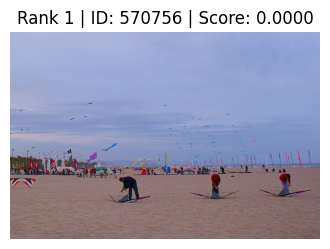

  2. Image ID = 540932 | Similarity = 0.0000


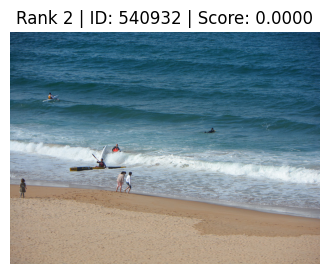

  3. Image ID = 465675 | Similarity = 0.0000


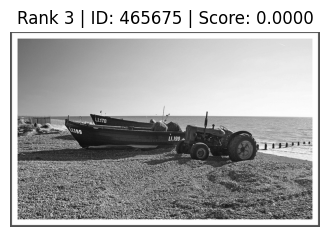

  4. Image ID = 364557 | Similarity = 0.0000


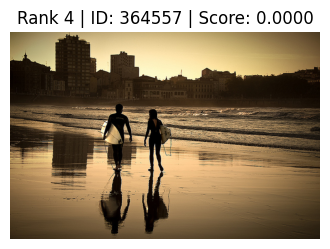

  5. Image ID = 347664 | Similarity = 0.0000


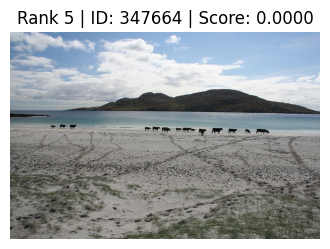

In [33]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Sửa đường dẫn tới folder ảnh
image_folder = r"E:/Download/val2017"

# Sắp xếp theo độ tương đồng
scored_images.sort(key=lambda x: x[1], reverse=True)

print("\n🔍 Top ảnh khớp với caption:")
for rank, (img_id, sim) in enumerate(scored_images[:5], 1):
    print(f"  {rank}. Image ID = {img_id} | Similarity = {sim:.4f}")
    
    # Định dạng tên file ảnh: thêm số 0 vào đầu để đủ 12 chữ số
    filename = f"{img_id:012d}.jpg"
    image_path = os.path.join(image_folder, filename)

    # Hiển thị ảnh nếu tồn tại
    if os.path.exists(image_path):
        image = Image.open(image_path)
        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Rank {rank} | ID: {img_id} | Score: {sim:.4f}")
        plt.show()
    else:
        print(f"❌ Không tìm thấy ảnh: {image_path}")


In [36]:
from collections import Counter
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def find_images_by_triplets_with_embedding(caption, entity_encoder, entity_embeddings, entity_id_to_images, extract_triplets, nlp):
    print(f"\n📝 Caption: {caption}")
    triplets = extract_triplets(caption)
    print(f"→ Trích được {len(triplets)} triplet:")
    for t in triplets:
        print("  -", t)

    # Hàm chuyển entity về ID (nếu có trong encoder)
    def get_id(word):
        if not word:
            return None
        try:
            return entity_encoder.transform([word.lower()])[0]
        except:
            return None

    image_counter = Counter()
    valid_entity_ids = set()

    if not triplets:
        print("⚠️ Không trích được triplet nào, dùng fallback từ khóa.")
        doc = nlp(caption)
        for token in doc:
            if token.pos_ in ("NOUN", "VERB", "PROPN"):
                eid = get_id(token.text)
                if eid is not None:
                    valid_entity_ids.add(eid)
    else:
        for s, p, o in triplets:
            for word in (s, p, o):
                eid = get_id(word)
                if eid is not None:
                    valid_entity_ids.add(eid)

    if not valid_entity_ids:
        print("⚠️ Không có entity hợp lệ trong caption.")
        return []

    # Tìm tất cả ảnh liên quan đến ít nhất 1 entity
    related_images = []
    for eid in valid_entity_ids:
        related_images.extend(entity_id_to_images.get(eid, []))

    if not related_images:
        print("⚠️ Không tìm thấy ảnh liên quan.")
        return []

    # Đếm số lần xuất hiện của ảnh (ưu tiên ảnh có nhiều entity)
    image_counter.update(related_images)

    # Tính trung bình vector embedding cho các entity trong caption
    query_vecs = [entity_embeddings[eid] for eid in valid_entity_ids if eid < entity_embeddings.shape[0]]
    query_mean = np.mean(query_vecs, axis=0).reshape(1, -1)

    # Tính độ tương đồng cosine giữa vector query và vector ảnh
    scored_images = []
    for image_id in image_counter:
        # Lấy các entity liên quan đến ảnh này
        image_entity_ids = [eid for eid, imgs in entity_id_to_images.items() if image_id in imgs]
        image_vecs = [entity_embeddings[eid] for eid in image_entity_ids if eid < entity_embeddings.shape[0]]
        if image_vecs:
            sim = cosine_similarity(query_mean, np.mean(image_vecs, axis=0).reshape(1, -1))[0][0]
            scored_images.append((image_id, sim))

    # Sắp xếp theo độ tương đồng
    scored_images.sort(key=lambda x: x[1], reverse=True)

    print(f"\n🔍 Tìm được {len(scored_images)} ảnh liên quan:")
    filenames = [f"{int(img_id):012}.jpg" for img_id, _ in scored_images]
    for name in filenames[:10]:
        print(" -", name)

    return filenames

In [37]:
caption = "A boy riding a horse on the beach"

filenames = find_images_by_triplets_with_embedding(
    caption=caption,
    entity_encoder=entity_encoder,
    entity_embeddings=entity_embeddings,
    entity_id_to_images=entity_id_to_images,
    extract_triplets=extract_triplets,  # chính hàm bạn đã viết
    nlp=nlp
)


📝 Caption: A boy riding a horse on the beach
→ Trích được 4 triplet:
  - ('boy', 'riding', 'horse')
  - ('boy', 'riding', 'beach')
  - ('boy', 'riding', 'horse')
  - ('boy', 'riding', None)

🔍 Tìm được 165 ảnh liên quan:
 - 000000377486.jpg
 - 000000030675.jpg
 - 000000131273.jpg
 - 000000275392.jpg
 - 000000323355.jpg
 - 000000377670.jpg
 - 000000250205.jpg
 - 000000080340.jpg
 - 000000229111.jpg
 - 000000084674.jpg


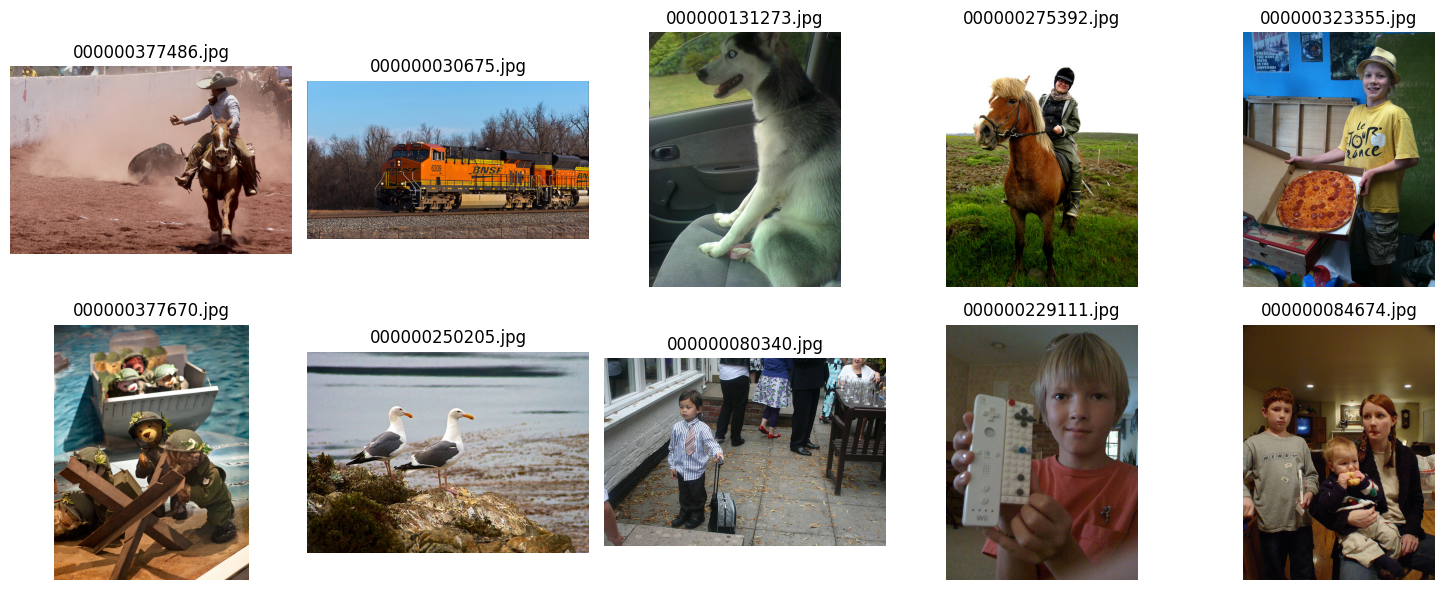

In [39]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def show_images_from_filenames(filenames, image_dir, max_images=10):
    plt.figure(figsize=(15, 6))
    for i, filename in enumerate(filenames[:max_images]):
        image_path = os.path.join(image_dir, filename)
        if os.path.exists(image_path):
            img = Image.open(image_path)
            plt.subplot(2, (max_images + 1) // 2, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(filename)
        else:
            print(f"⚠️ Không tìm thấy: {image_path}")
    plt.tight_layout()
    plt.show()

# === Gọi hàm hiển thị với thư mục val2017 ===
show_images_from_filenames(
    filenames=filenames,
    image_dir="E:/Download/val2017",
    max_images=10  # hiển thị top 10 ảnh
)

In [40]:
import pandas as pd

# Đọc lại triplets
df = pd.read_csv("triplets.csv")

# Hàm lấy image_id từ tên file
def extract_image_id(filename):
    return int(filename.replace(".jpg", ""))

# Ví dụ: lấy triplets của các ảnh đầu tiên trong danh sách filenames
for filename in filenames[:10]:
    img_id = extract_image_id(filename)
    triplet_rows = df[df['image_id'] == img_id][['subject', 'predicate', 'object']]
    print(f"\n📸 Image ID: {img_id} ({filename})")
    if triplet_rows.empty:
        print("⚠️ Không có triplet nào.")
    else:
        for _, row in triplet_rows.iterrows():
            print(" -", tuple(row))


📸 Image ID: 377486 (000000377486.jpg)
 - ('person', 'riding', 'horse')
 - ('person', 'riding', 'dirt')
 - ('person', 'riding', 'wall')
 - ('horse', 'with', 'person')
 - ('top', 'of', 'it')
 - ('person', 'riding', 'top')
 - ('man', 'on', 'horse')
 - ('man', 'looking', 'bull')
 - ('wall', 'has', 'cloud')
 - ('which', 'shows', 'people')
 - ('closest', 'trotting', 'man')
 - ('who', 'looking', 'bull')
 - ('people', 'over', 'rim')
 - ('cloud', 'of', 'dust')
 - ('man', 'in', 'gear')
 - ('wall', 'amod', 'large')
 - ('wall', 'amod', 'square')
 - ('wall', 'amod', 'concrete')
 - ('cloud', 'amod', 'pinkish')
 - ('bull', 'amod', 'fallen')
 - ('gear', 'amod', 'western')
 - ('cloud', 'and', 'bull')
 - ('bull', 'and', 'horses')
 - ('dirt-ground', 'compound', 'ground')
 - ('person', 'riding', 'ground')

📸 Image ID: 30675 (000000030675.jpg)
 - ('train-engine', 'compound', 'engine')
 - ('engine-number', 'compound', 'number')
 - ('train', 'amod', 'long')
 - ('forest', 'amod', 'filled')
 - ('orange-train'

In [41]:
from collections import OrderedDict
from IPython.display import display
from PIL import Image
import os

def extract_image_id(filename):
    return int(filename.replace(".jpg", ""))

def get_image_ids_from_triplet(triplet, entity_encoder, entity_id_to_images):
    s, p, o = triplet
    ids = []
    try:
        s_id = entity_encoder.transform([s])[0] if s else None
        p_id = entity_encoder.transform([p])[0] if p else None
        o_id = entity_encoder.transform([o])[0] if o else None
    except:
        return set()

    s_imgs = set(entity_id_to_images.get(s_id, [])) if s_id is not None else set()
    p_imgs = set(entity_id_to_images.get(p_id, [])) if p_id is not None else set()
    o_imgs = set(entity_id_to_images.get(o_id, [])) if o_id is not None else set()

    if s_id is not None and p_id is not None and o_id is not None:
        return s_imgs & p_imgs & o_imgs or s_imgs & o_imgs
    elif s_id is not None and o_id is not None:
        return s_imgs & o_imgs
    elif s_id is not None and p_id is not None:
        return s_imgs & p_imgs
    elif o_id is not None and p_id is not None:
        return o_imgs & p_imgs
    elif s_id is not None:
        return s_imgs
    elif o_id is not None:
        return o_imgs
    return set()

# === Quét theo thứ tự triplet ===
def prioritize_images_by_triplet_order(triplets, entity_encoder, entity_id_to_images, image_folder):
    seen = set()
    ordered_images = []

    for idx, triplet in enumerate(triplets):
        image_ids = get_image_ids_from_triplet(triplet, entity_encoder, entity_id_to_images)
        new_images = [img_id for img_id in image_ids if img_id not in seen]
        seen.update(new_images)
        ordered_images.extend(new_images)
        print(f"\n🔍 Triplet {idx+1}: {triplet} → {len(new_images)} ảnh mới")

    # Hiển thị ảnh
    for img_id in ordered_images[:10]:  # chỉ hiển thị 10 ảnh đầu
        img_path = os.path.join(image_folder, f"{int(img_id):012}.jpg")
        print(f"🖼 {img_path}")
        display(Image.open(img_path))

# === Sử dụng ===
image_folder = "E:/Download/val2017"
triplets = [('boy', 'riding', 'horse'), ('boy', 'riding', 'beach'), ('boy', 'riding', 'horse'), ('boy', 'riding', None)]

prioritize_images_by_triplet_order(
    triplets=triplets,
    entity_encoder=entity_encoder,
    entity_id_to_images=entity_id_to_images,
    image_folder=image_folder
)


🔍 Triplet 1: ('boy', 'riding', 'horse') → 0 ảnh mới

🔍 Triplet 2: ('boy', 'riding', 'beach') → 0 ảnh mới

🔍 Triplet 3: ('boy', 'riding', 'horse') → 0 ảnh mới

🔍 Triplet 4: ('boy', 'riding', None) → 0 ảnh mới


In [42]:
for word in ['boy', 'riding', 'horse', 'beach']:
    if word in entity_encoder.classes_:
        print(f"✅ Có entity: {word}")
    else:
        print(f"❌ Thiếu entity: {word}")


✅ Có entity: boy
✅ Có entity: riding
✅ Có entity: horse
✅ Có entity: beach


In [43]:
eid = entity_encoder.transform(['horse'])[0]
print("Ảnh chứa 'horse':", entity_id_to_images.get(eid, []))


Ảnh chứa 'horse': [29187, 97924, 553990, 481159, 382088, 260106, 460682, 377486, 381971, 353051, 263966, 382111, 463522, 304291, 439715, 356261, 380203, 481582, 191288, 462904, 227898, 576955, 275392, 118209, 308545, 199236, 47819, 368335, 456015, 529105, 372307, 15956, 23126, 265816, 166747, 40036, 16228, 227686, 356968, 269932, 51309, 61171, 49269, 23034]


In [44]:
print("Entity classes:", list(entity_encoder.classes_)[:20])


Entity classes: ["'s", '1950s', 'a', 'a-game', 'abandoned', 'about', 'abundance', 'academic', 'accent', 'accents', 'accessories', 'achild', 'action', 'actors', 'ad', 'adorable', 'adult', 'adult-elephant', 'adult-giraffe', 'adult-males']


In [45]:
import pandas as pd

# Đọc file triplets
df = pd.read_csv("triplets.csv")

# Tách image_id từ tên file ảnh
target_image_id = int("000000040036.jpg".replace(".jpg", ""))

# Lọc triplet theo image_id
matching_triplets = df[df['image_id'] == target_image_id][['subject', 'predicate', 'object']]

# Hiển thị kết quả
print(f"📸 Triplets cho ảnh 000000040036.jpg (ID: {target_image_id}):")
if matching_triplets.empty:
    print("⚠️ Không tìm thấy triplet nào.")
else:
    for _, row in matching_triplets.iterrows():
        print(" -", tuple(row))


📸 Triplets cho ảnh 000000040036.jpg (ID: 40036):
 - ('person', 'jumping', 'horse')
 - ('person', 'jumping', 'box')
 - ('rider', 'on', 'horse')
 - ('horse', 'jumping', 'fence')
 - ('person', 'jumping', 'obstacle')
 - ('obstacle', 'amod', 'wooden')
 - ('person', 'riding', 'horse')
 - ('person', 'makes', 'jump')
 - ('person', 'on', 'horse')
 - ('person', 'amod', 'young')


In [46]:
import pickle

with open("synonym_map.pkl", "rb") as f:
    synonym_map = pickle.load(f)

In [47]:
from collections import Counter
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def find_images_by_triplets_with_embedding(
    caption,
    entity_encoder,
    entity_embeddings,
    entity_id_to_images,
    extract_triplets,
    nlp,
    synonym_map  # ← Thêm map từ đồng nghĩa
):
    print(f"\n📝 Caption: {caption}")
    triplets = extract_triplets(caption)
    print(f"→ Trích được {len(triplets)} triplet:")
    for t in triplets:
        print("  -", t)

    def normalize(word):
        if not word:
            return None
        word = word.lower()
        return synonym_map.get(word, word)  # nếu có map thì dùng

    def get_id(word):
        norm = normalize(word)
        if not norm:
            return None
        try:
            return entity_encoder.transform([norm])[0]
        except:
            return None

    image_counter = Counter()
    valid_entity_ids = set()

    if not triplets:
        print("⚠️ Không trích được triplet nào, dùng fallback từ khóa.")
        doc = nlp(caption)
        for token in doc:
            if token.pos_ in ("NOUN", "VERB", "PROPN"):
                eid = get_id(token.text)
                if eid is not None:
                    valid_entity_ids.add(eid)
    else:
        for s, p, o in triplets:
            for word in (s, p, o):
                eid = get_id(word)
                if eid is not None:
                    valid_entity_ids.add(eid)

    if not valid_entity_ids:
        print("⚠️ Không có entity hợp lệ trong caption.")
        return []

    # Tìm ảnh liên quan
    related_images = []
    for eid in valid_entity_ids:
        related_images.extend(entity_id_to_images.get(eid, []))
    if not related_images:
        print("⚠️ Không tìm thấy ảnh liên quan.")
        return []

    image_counter.update(related_images)

    query_vecs = [entity_embeddings[eid] for eid in valid_entity_ids if eid < entity_embeddings.shape[0]]
    query_mean = np.mean(query_vecs, axis=0).reshape(1, -1)

    scored_images = []
    for image_id in image_counter:
        image_entity_ids = [eid for eid, imgs in entity_id_to_images.items() if image_id in imgs]
        image_vecs = [entity_embeddings[eid] for eid in image_entity_ids if eid < entity_embeddings.shape[0]]
        if image_vecs:
            sim = cosine_similarity(query_mean, np.mean(image_vecs, axis=0).reshape(1, -1))[0][0]
            scored_images.append((image_id, sim))

    scored_images.sort(key=lambda x: x[1], reverse=True)

    print(f"\n🔍 Tìm được {len(scored_images)} ảnh liên quan:")
    filenames = [f"{int(img_id):012}.jpg" for img_id, _ in scored_images]
    for name in filenames[:10]:
        print(" -", name)

    return filenames

In [49]:
filenames = find_images_by_triplets_with_embedding(
    caption="A boy riding a horse on the beach",
    entity_encoder=entity_encoder,
    entity_embeddings=entity_embeddings,
    entity_id_to_images=entity_id_to_images,
    extract_triplets=extract_triplets,
    nlp=nlp,
    synonym_map=synonym_map
)



📝 Caption: A boy riding a horse on the beach
→ Trích được 4 triplet:
  - ('boy', 'riding', 'horse')
  - ('boy', 'riding', 'beach')
  - ('boy', 'riding', 'horse')
  - ('boy', 'riding', None)

🔍 Tìm được 278 ảnh liên quan:
 - 000000377486.jpg
 - 000000030675.jpg
 - 000000439426.jpg
 - 000000557672.jpg
 - 000000131273.jpg
 - 000000275392.jpg
 - 000000181421.jpg
 - 000000402118.jpg
 - 000000331817.jpg
 - 000000003553.jpg


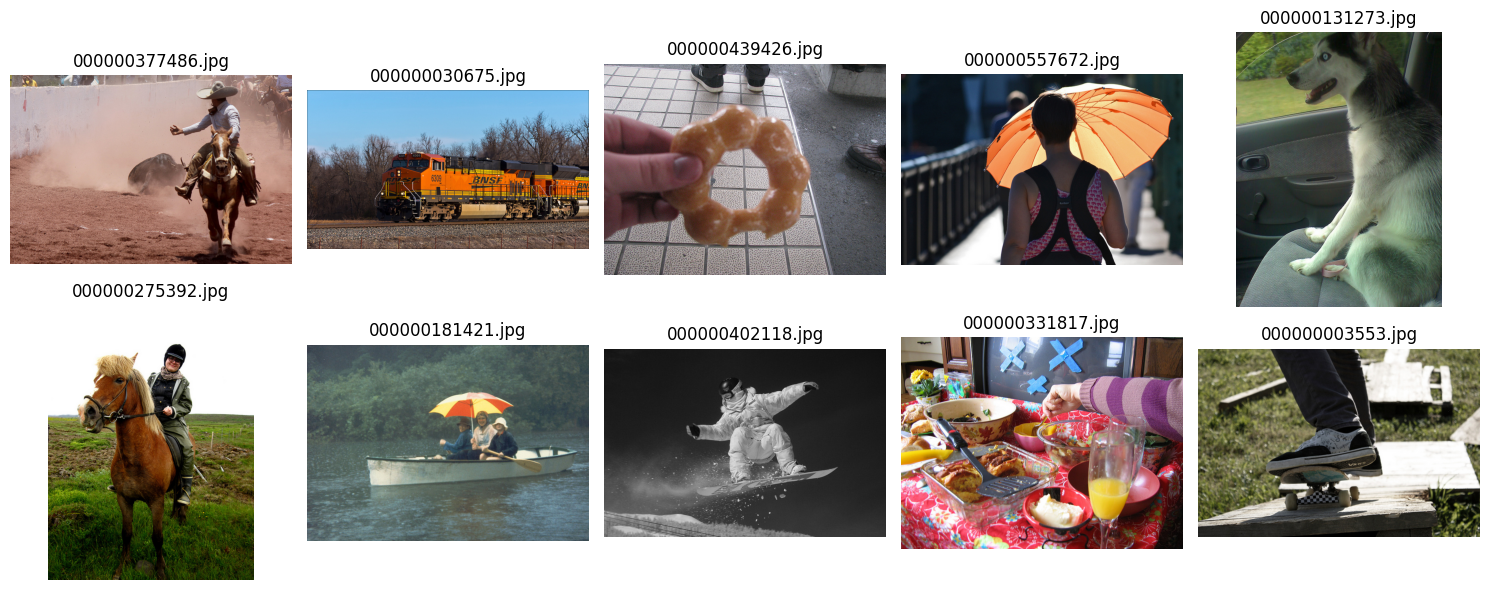

In [50]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def show_images_from_filenames(filenames, image_dir, max_images=10):
    plt.figure(figsize=(15, 6))
    for i, filename in enumerate(filenames[:max_images]):
        image_path = os.path.join(image_dir, filename)
        if os.path.exists(image_path):
            img = Image.open(image_path)
            plt.subplot(2, (max_images + 1) // 2, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(filename)
        else:
            print(f"⚠️ Không tìm thấy: {image_path}")
    plt.tight_layout()
    plt.show()

# === Gọi hàm hiển thị với thư mục val2017 ===
show_images_from_filenames(
    filenames=filenames,
    image_dir="E:/Download/val2017",
    max_images=10  # hiển thị top 10 ảnh
)

In [51]:
import pandas as pd

# Đọc lại triplets
df = pd.read_csv("triplets.csv")

# Hàm lấy image_id từ tên file
def extract_image_id(filename):
    return int(filename.replace(".jpg", ""))

# Ví dụ: lấy triplets của các ảnh đầu tiên trong danh sách filenames
for filename in filenames[:10]:
    img_id = extract_image_id(filename)
    triplet_rows = df[df['image_id'] == img_id][['subject', 'predicate', 'object']]
    print(f"\n📸 Image ID: {img_id} ({filename})")
    if triplet_rows.empty:
        print("⚠️ Không có triplet nào.")
    else:
        for _, row in triplet_rows.iterrows():
            print(" -", tuple(row))


📸 Image ID: 377486 (000000377486.jpg)
 - ('person', 'riding', 'horse')
 - ('person', 'riding', 'dirt')
 - ('person', 'riding', 'wall')
 - ('horse', 'with', 'person')
 - ('top', 'of', 'it')
 - ('person', 'riding', 'top')
 - ('man', 'on', 'horse')
 - ('man', 'looking', 'bull')
 - ('wall', 'has', 'cloud')
 - ('which', 'shows', 'people')
 - ('closest', 'trotting', 'man')
 - ('who', 'looking', 'bull')
 - ('people', 'over', 'rim')
 - ('cloud', 'of', 'dust')
 - ('man', 'in', 'gear')
 - ('wall', 'amod', 'large')
 - ('wall', 'amod', 'square')
 - ('wall', 'amod', 'concrete')
 - ('cloud', 'amod', 'pinkish')
 - ('bull', 'amod', 'fallen')
 - ('gear', 'amod', 'western')
 - ('cloud', 'and', 'bull')
 - ('bull', 'and', 'horses')
 - ('dirt-ground', 'compound', 'ground')
 - ('person', 'riding', 'ground')

📸 Image ID: 30675 (000000030675.jpg)
 - ('train-engine', 'compound', 'engine')
 - ('engine-number', 'compound', 'number')
 - ('train', 'amod', 'long')
 - ('forest', 'amod', 'filled')
 - ('orange-train'